# Exercise 5

## 1 Constructing the matrix X 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import sparse

In [2]:
def construct_X(M, alphas, Np = None):
    if Np is None:
        Np = np.ceil(np.sqrt(2) * M)
        if Np % 2 == 0: Np += 1 # make Np odd
    s0 = (Np - 1) / 2 #center sensor array
    
    #convert to radians
    alphas = np.array(alphas, dtype=np.float32) / 180 * np.pi 
    
    # some dimensions 
    Na = len(alphas)
    N = Np * Na
    D = M * M
    
    # array holding coordinates of the tomograms pixels
    x, y = np.flip((np.mgrid[0:M, 0:M] - M/2 + .5).reshape(2, -1), axis=0) 
    C = np.array([x, np.flip(y, 0)]) # 2 x D
    
    # normals to the sensor array at different orientations
    n = np.array([np.cos(alphas), np.sin(alphas)], dtype = np.float32) # 2 x Na
    
    # doing the projections
    p = (np.dot(n.transpose(), C) + s0) # Na x D, in range(Np)
    
    # constructing weight and index arrays for X
    lower_bins = np.floor(p)
    lower_bin_weights = 1 - (p - lower_bins)
    upper_bins = lower_bins + 1
    upper_bin_weights = 1 - lower_bin_weights
    
    weights = np.concatenate((lower_bin_weights.reshape(-1), 
                              upper_bin_weights.reshape(-1))) # length: 2 * Na * D
    
    i_indices = np.concatenate((lower_bins.reshape(-1) + Np * np.repeat(np.arange(Na), D), 
                                upper_bins.reshape(-1) + Np * np.repeat(np.arange(Na), D))) # in range(Na*Np)
    j_indices = np.indices(p.shape)[1].flatten()
    j_indices = np.tile(j_indices, 2) # duplicate for upper/lower bins
    
    # construct X matrix
    X = sparse.coo_matrix((weights, (i_indices, j_indices)), shape=(N, D), dtype = np.float32)
    
    return X

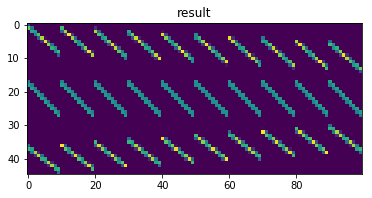

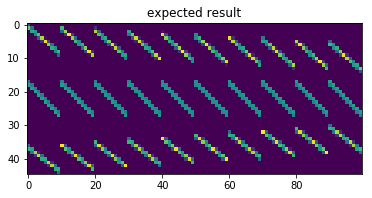

maximum deviation from expected result: 1.341104507446289e-07


In [3]:
M = 10
Np = 15
alphas = [-33, 1, 42]

X_test = construct_X(M, alphas)

plt.imshow(X_test.toarray())
plt.title('result')
plt.show()

X_example = np.load('hs_tomography/X_example.npy')
plt.imshow(X_example)
plt.title('expected result')
plt.show()

print('maximum deviation from expected result: {}'.format(np.max(X_test - X_example)))

## 2 Recovering the image

importing the data

In [4]:
def describe(name, a):
    print('{}: shape: {}, dtype: {}'.format(name, a.shape, a.dtype))

In [5]:
alphas_195 = np.load('hs_tomography/alphas_195.npy')
alphas_77 = np.load('hs_tomography/alphas_77.npy')

y_195 = np.load('hs_tomography/y_195.npy')
y_77 = np.load('hs_tomography/y_77.npy')

describe('alphas_195', alphas_195)
describe('alphas_77', alphas_77)
describe('y_195', y_195)
describe('y_77', y_77)

alphas_195: shape: (179,), dtype: int64
alphas_77: shape: (90,), dtype: int64
y_195: shape: (49225,), dtype: float64
y_77: shape: (9810,), dtype: float32


In [6]:
X = construct_X(195, alphas_195, 275)
sparsity = X.count_nonzero() / X.size
print('sparsity of X: {:4.2f}%'.format(100*sparsity))

sparsity of X: 99.71%


In [7]:
from scipy.sparse import linalg

def reconstruct_image(alphas, y, M, tol=1e-5):
    assert len(y) % len(alphas) == 0
    Np = len(y) / len(alphas)
    X = construct_X(M, alphas, Np)
    beta = sparse.linalg.lsqr(sparse.csc_matrix(X), y, atol=tol, btol=tol)[0]
    return beta.reshape(M, M)

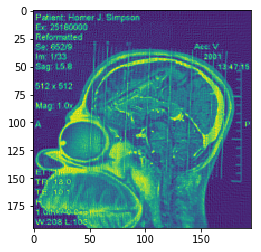

In [8]:
img = reconstruct_image(alphas_195, y_195, 195)
plt.imshow(img)
plt.show()

## 3 Minimizing the radiation dose

In [9]:
def reduce_projection_angles(alphas, y, n):
    ind = np.floor(np.arange(n) / n * len(alphas)).astype(np.int32)
    new_alphas = alphas[ind]
    new_y = (y.reshape((alphas.size, -1))[ind, :]).reshape(-1)
    return new_alphas, new_y

def reconstruct_image_reduced_angles(alphas, y, M, Na, tol=1e-5):
    new_alphas, new_y = reduce_projection_angles(alphas, y, Na)
    return reconstruct_image(new_alphas, new_y, M, tol)

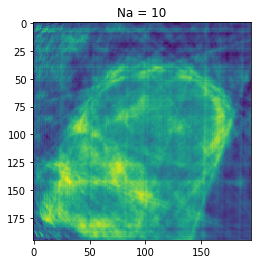

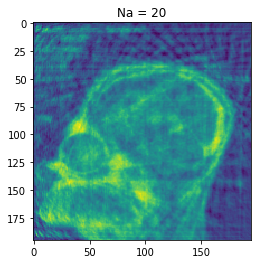

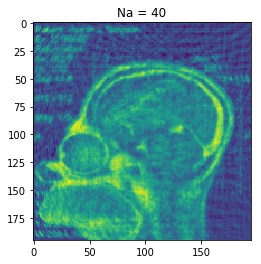

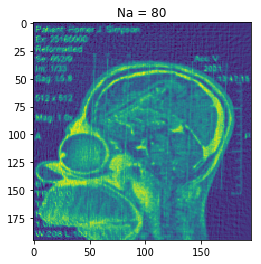

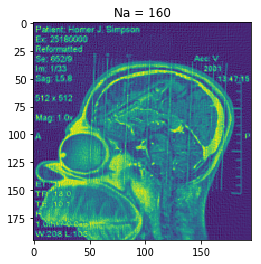

In [10]:
def show_reduced(Na):
    img = reconstruct_image_reduced_angles(alphas_195, y_195, 195, Na, tol=1e-5)
    plt.imshow(img)
    plt.title('Na = {}'.format(Na))
    plt.show()
    
for Na in [10, 20, 40, 80, 160]:
    show_reduced(Na)

I would say one needs about $N_a = 80$ scans to solve the case.